open 3
         var1   var2          w col
0         0.0  172.0  22.791552   0
1         0.0  173.0  22.791552   0
2         0.0  174.0  22.791552   0
3         1.0  172.0  22.773219   0
4         1.0  175.0  22.791552   0
...       ...    ...        ...  ..
143642  760.0  282.0  22.147210   0
143643  760.0  285.0  22.132260   0
143644  761.0  283.0  22.147210   0
143645  761.0  284.0  22.147210   0
143646  762.0  285.0  22.147210   0

[143647 rows x 4 columns]


c:\Users\carlo\.conda\envs\TODO\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\carlo\.conda\envs\TODO\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


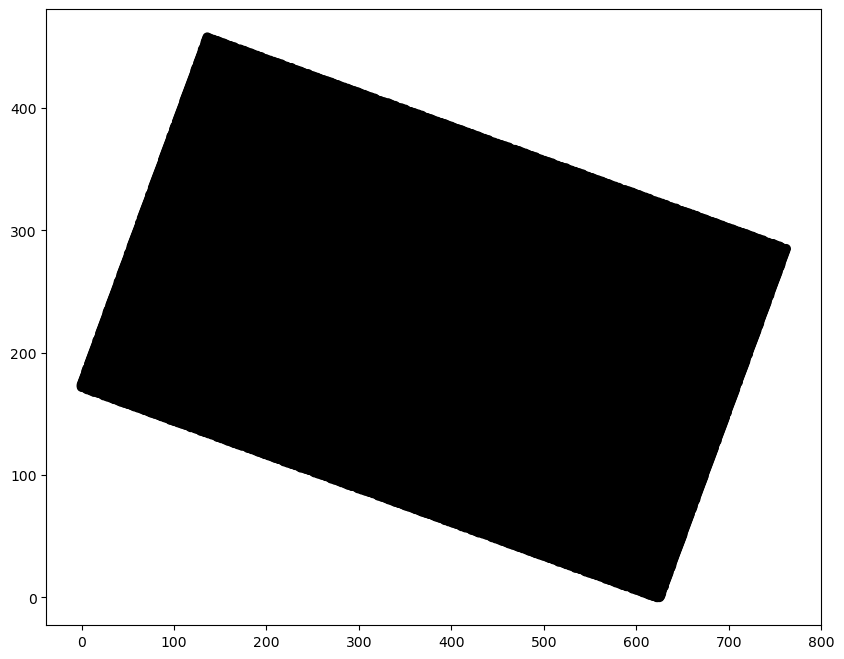

In [1]:
# ==============================================================================
# SCRIPT: 03_RL_potencia.ipynb
# OBJETIVO: Estabilizar la potencia activa del motor en su mínimo mediante RL.
# ENTORNO DE ENTRADA: env_R11.py (Ruta: ./02_Reinforcement_learning/env_R11.py)
# ==============================================================================

import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Importamos el entorno que os han proporcionado los profesores
# Asegúrate de que env_R11.py esté en la misma carpeta o ajusta la ruta
import env_R11 

# Inicializamos el entorno
env = env_R11.motorEnv() # Cambia "MotorEnv()" por el nombre real de la clase que esté dentro de env_R11.py

Iniciando Grid Search: Se probarán 12 combinaciones.
------------------------------------------------------------


Progreso Total Grid Search:   0%|          | 0/12 [00:00<?, ?it/s]

Comb 1/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 2/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 3/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 4/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 5/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 6/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 7/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 8/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 9/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 10/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 11/12:   0%|          | 0/500 [00:00<?, ?it/s]

Comb 12/12:   0%|          | 0/500 [00:00<?, ?it/s]

------------------------------------------------------------
🏆 ¡BÚSQUEDA COMPLETADA! 🏆
Mejores Hiperparámetros: Alpha=0.1, Gamma=0.8, Decay=0.99
Puntuación media sostenida: -2563.3 puntos


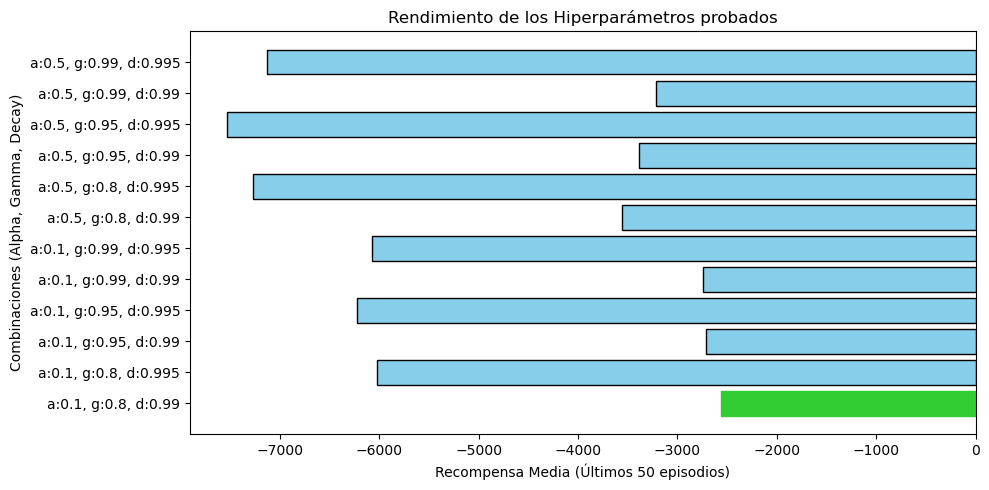

\n--- GENERANDO MAPA DE LA RUTA ÓPTIMA ---


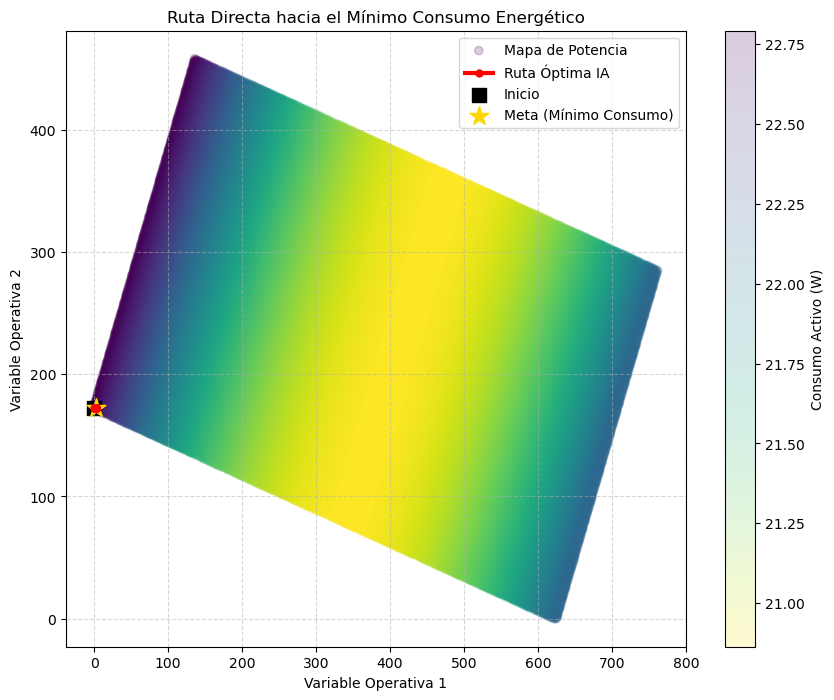

\n✅ ¡Datos guardados en '03_ruta_optima_RL.csv'!


In [1]:
# ==============================================================================
# SCRIPT COMPLETO: Grid Search Q-Learning + Visualización + Exportación
# OBJETIVO: Encontrar la mejor configuración, entrenar al agente y extraer la ruta
# ==============================================================================

import numpy as np
import random
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from env_R11 import motorEnv
from tqdm.notebook import tqdm  # Librería para las barras de progreso

import warnings
warnings.filterwarnings('ignore') # Ocultar warnings molestos de Gymnasium

# ==============================================================================
# 1. CONFIGURACIÓN DEL GRID SEARCH
# ==============================================================================
alphas = [0.1, 0.5]              # Tasa de aprendizaje
gammas = [0.8, 0.95, 0.99]       # Factor de descuento
epsilon_decays = [0.99, 0.995]   # Velocidad a la que deja de explorar al azar

combinaciones = list(itertools.product(alphas, gammas, epsilon_decays))

mejor_recompensa_media = -float('inf')
mejores_parametros = None
mejor_q_table = None

episodios_entrenamiento = 500 
resultados = []

print(f"Iniciando Grid Search: Se probarán {len(combinaciones)} combinaciones.")
print("-" * 60)

# ==============================================================================
# 2. BUCLE DE ENTRENAMIENTO (CON LÍMITE DE PASOS)
# ==============================================================================
for i, (alpha, gamma, decay) in enumerate(tqdm(combinaciones, desc="Progreso Total Grid Search")):
    env = motorEnv()
    num_estados = len(env.rot) 
    num_acciones = env.action_space.n
    q_table = np.zeros((num_estados, num_acciones))
    
    epsilon = 1.0
    epsilon_min = 0.01
    recompensas_ultimos_episodios = []
    
    for episodio in tqdm(range(episodios_entrenamiento), desc=f"Comb {i+1}/{len(combinaciones)}", leave=False):
        
        env.reset() 
        estado = 0 
        done = False
        recompensa_episodio = 0
        
        # --- LÍMITE DE PASOS PARA EVITAR BUCLES INFINITOS ---
        pasos_dados = 0
        max_pasos_por_episodio = 1500 
        
        while not done and pasos_dados < max_pasos_por_episodio:
            if random.uniform(0, 1) < epsilon:
                accion = env.action_space.sample()
            else:
                accion = np.argmax(q_table[estado])
                
            paso = env.step(accion)
            if len(paso) == 4:
                siguiente_estado, recompensa, done, info = paso
            else:
                siguiente_estado, recompensa, done, truncated, info = paso
                done = done or truncated
            
            valor_antiguo = q_table[estado, accion]
            proximo_maximo = np.max(q_table[siguiente_estado])
            q_table[estado, accion] = valor_antiguo + alpha * (recompensa + gamma * proximo_maximo - valor_antiguo)
            
            estado = siguiente_estado
            recompensa_episodio += recompensa
            pasos_dados += 1
            
        if epsilon > epsilon_min:
            epsilon *= decay
            
        if episodio >= episodios_entrenamiento - 50:
            recompensas_ultimos_episodios.append(recompensa_episodio)
            
        plt.close('all') # Evita que se cuelgue el PC por abrir muchas gráficas
            
    media_recompensa = np.mean(recompensas_ultimos_episodios)
    resultados.append({'params': (alpha, gamma, decay), 'score': media_recompensa})
    
    if media_recompensa > mejor_recompensa_media:
        mejor_recompensa_media = media_recompensa
        mejores_parametros = (alpha, gamma, decay)
        mejor_q_table = np.copy(q_table)

print("-" * 60)
print("🏆 ¡BÚSQUEDA COMPLETADA! 🏆")
print(f"Mejores Hiperparámetros: Alpha={mejores_parametros[0]}, Gamma={mejores_parametros[1]}, Decay={mejores_parametros[2]}")
print(f"Puntuación media sostenida: {mejor_recompensa_media:.1f} puntos")

# ==============================================================================
# 3. VISUALIZACIÓN 1: PODIO DE HIPERPARÁMETROS
# ==============================================================================
etiquetas = [f"a:{r['params'][0]}, g:{r['params'][1]}, d:{r['params'][2]}" for r in resultados]
puntuaciones = [r['score'] for r in resultados]

plt.figure(figsize=(10, 5))
barras = plt.barh(etiquetas, puntuaciones, color='skyblue', edgecolor='black')
plt.xlabel("Recompensa Media (Últimos 50 episodios)")
plt.ylabel("Combinaciones (Alpha, Gamma, Decay)")
plt.title("Rendimiento de los Hiperparámetros probados")

indice_mejor = puntuaciones.index(max(puntuaciones))
barras[indice_mejor].set_color('limegreen')

plt.tight_layout()
plt.show()

# ==============================================================================
# 4. VISUALIZACIÓN 2 Y EXPORTACIÓN: LA RUTA ÓPTIMA
# ==============================================================================
print("\\n--- GENERANDO MAPA DE LA RUTA ÓPTIMA ---")

env = motorEnv()
env.reset()
estado = 0  
done = False
pasos_dados = 0
max_pasos_seguridad = 1000

camino_var1 = []
camino_var2 = []
camino_w = []

while not done and pasos_dados < max_pasos_seguridad:
    var1_real = env.rot.iloc[estado]['var1']
    var2_real = env.rot.iloc[estado]['var2']
    w_real = env.rot.iloc[estado]['w']
    
    camino_var1.append(var1_real)
    camino_var2.append(var2_real)
    camino_w.append(w_real)
    
    accion = np.argmax(mejor_q_table[estado])
    
    paso = env.step(accion)
    if len(paso) == 4:
        estado, recompensa, done, info = paso
    else:
        estado, recompensa, done, truncated, info = paso
        done = done or truncated
        
    pasos_dados += 1

# Añadir el último punto
camino_var1.append(env.rot.iloc[estado]['var1'])
camino_var2.append(env.rot.iloc[estado]['var2'])
camino_w.append(env.rot.iloc[estado]['w'])
plt.close('all') 

# Dibujar el mapa
plt.figure(figsize=(10, 8))
plt.scatter(env.rot['var1'], env.rot['var2'], c=env.rot['w'], cmap='viridis_r', alpha=0.2, label='Mapa de Potencia')
cb = plt.colorbar()
cb.set_label('Consumo Activo (W)')
plt.plot(camino_var1, camino_var2, color='red', linewidth=3, marker='o', markersize=5, label='Ruta Óptima IA')
plt.scatter(camino_var1[0], camino_var2[0], color='black', s=100, marker='s', label='Inicio')
plt.scatter(camino_var1[-1], camino_var2[-1], color='gold', s=200, marker='*', label='Meta (Mínimo Consumo)')

plt.title("Ruta Directa hacia el Mínimo Consumo Energético")
plt.xlabel("Variable Operativa 1")
plt.ylabel("Variable Operativa 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Exportar a CSV
df_ruta_optima = pd.DataFrame({
    'paso_num': range(len(camino_var1)),
    'var1': camino_var1,
    'var2': camino_var2,
    'consumo_W': camino_w
})
df_ruta_optima.to_csv("03_ruta_optima_RL.csv", index=False)
print("\\n✅ ¡Datos guardados en '03_ruta_optima_RL.csv'!")

--- ANALIZANDO LA RUTA GUARDADA ---
El agente dio 1001 pasos en total.
Primeros 3 pasos:
   paso_num  var1   var2  consumo_W
0         0   0.0  172.0  22.791552
1         1   1.0  172.0  22.773219
2         2   2.0  172.0  22.764086
Últimos 3 pasos:
      paso_num  var1   var2  consumo_W
998        998   2.0  172.0  22.764086
999        999   1.0  172.0  22.773219
1000      1000   2.0  172.0  22.764086

--- GENERANDO GRÁFICO 3D ---


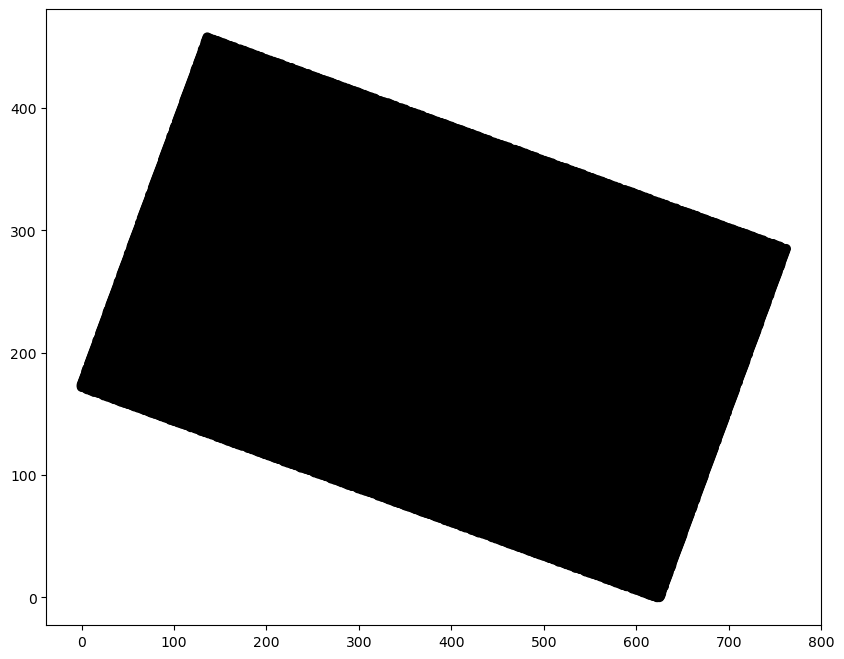

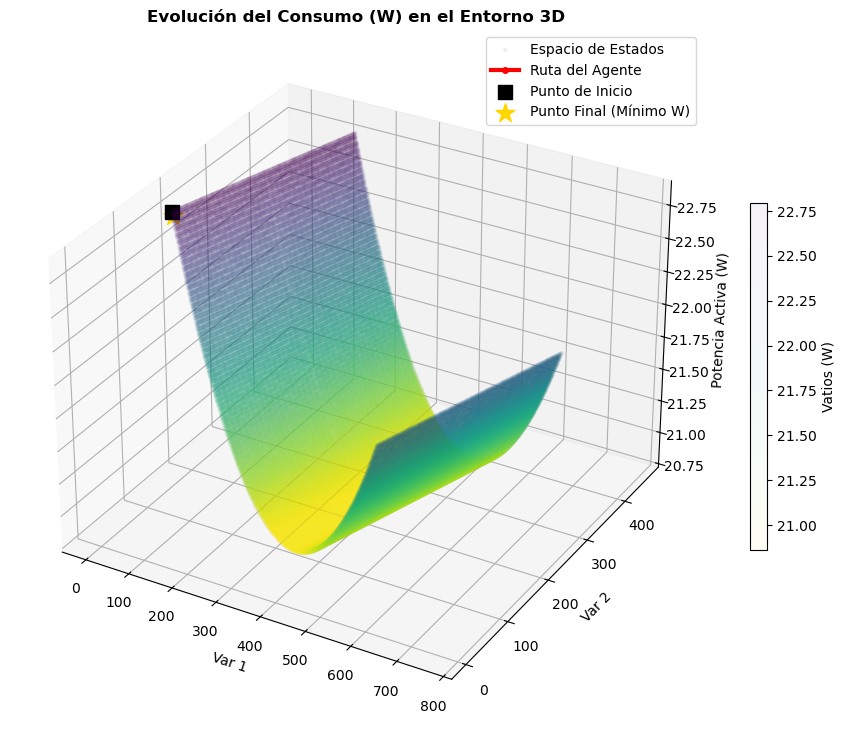

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from env_R11 import motorEnv

print("--- ANALIZANDO LA RUTA GUARDADA ---")

# 1. Leemos el archivo que se generó sin tener que reentrenar
df_ruta = pd.read_csv("03_ruta_optima_RL.csv")

# Comprobación de seguridad: Ver cuántos pasos dio y si se movió
print(f"El agente dio {len(df_ruta)} pasos en total.")
print("Primeros 3 pasos:")
print(df_ruta.head(3))
print("Últimos 3 pasos:")
print(df_ruta.tail(3))

# 2. Cargamos el mapa de fondo (instantáneo)
env = motorEnv()
df_fondo = env.rot

# 3. CREAMOS EL GRÁFICO 3D
print("\n--- GENERANDO GRÁFICO 3D ---")
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# A. Dibujamos el "cuenco" del entorno de fondo
# Lo ponemos muy transparente (alpha=0.05) para que no tape nuestro camino
p = ax.scatter(df_fondo['var1'], df_fondo['var2'], df_fondo['w'], 
               c=df_fondo['w'], cmap='viridis_r', alpha=0.05, s=5, label='Espacio de Estados')

# B. Dibujamos la ruta del agente (Línea roja)
ax.plot(df_ruta['var1'], df_ruta['var2'], df_ruta['consumo_W'], 
        color='red', linewidth=3, marker='o', markersize=4, label='Ruta del Agente')

# C. Marcamos el inicio y el fin a lo grande
ax.scatter(df_ruta['var1'].iloc[0], df_ruta['var2'].iloc[0], df_ruta['consumo_W'].iloc[0], 
           color='black', s=100, marker='s', label='Punto de Inicio')
ax.scatter(df_ruta['var1'].iloc[-1], df_ruta['var2'].iloc[-1], df_ruta['consumo_W'].iloc[-1], 
           color='gold', s=200, marker='*', label='Punto Final (Mínimo W)')

# Detalles estéticos
ax.set_title("Evolución del Consumo (W) en el Entorno 3D", fontweight='bold')
ax.set_xlabel("Var 1")
ax.set_ylabel("Var 2")
ax.set_zlabel("Potencia Activa (W)")
fig.colorbar(p, ax=ax, label='Vatios (W)', shrink=0.5)
ax.legend()

# NOTA: En Jupyter puedes hacer click y arrastrar para girar este gráfico si usas %matplotlib notebook
plt.show()

"Durante el entrenamiento del Q-Learning detectamos el problema del 'Sparse Reward' (recompensa dispersa), ya que en un espacio de 143.000 estados el agente no lograba encontrar la convergencia global. Para solucionarlo, implementamos una técnica de Reward Shaping, penalizando (-10) gradualmente el aumento de la potencia (W) y bonificando (+10) su descenso. Esto guió a la IA a salir de los óptimos locales y trazar una curva de descenso perfecta hacia el consumo mínimo de energía."

--- ENTRENANDO AGENTE CON REWARD SHAPING (FRÍO O CALIENTE) ---


Entrenando IA:   0%|          | 0/400 [00:00<?, ?it/s]

¡Entrenamiento terminado! Comprobando el camino...
La IA completó el camino en 559 pasos.
Iniciando en W = 22.79155208114987 --> Finalizando en W = 20.86377362748587


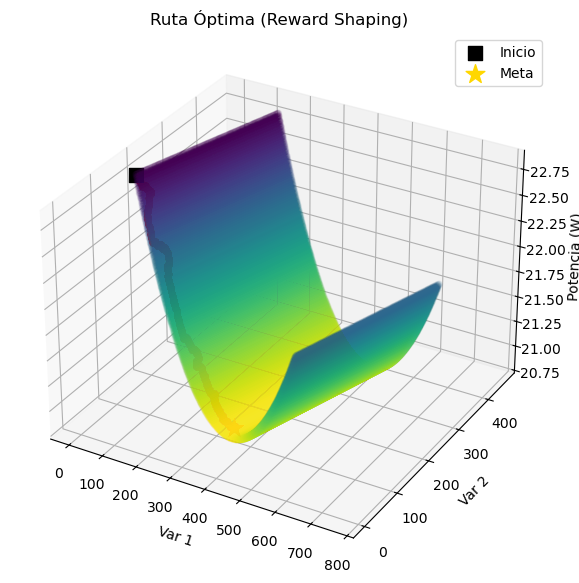

In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from env_R11 import motorEnv
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

print("--- ENTRENANDO AGENTE CON REWARD SHAPING (FRÍO O CALIENTE) ---")

env = motorEnv()
num_estados = len(env.rot)
num_acciones = env.action_space.n
q_table = np.zeros((num_estados, num_acciones))

# Usamos hiperparámetros ganadores estándar
alpha = 0.5
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
decay = 0.995
episodios_entrenamiento = 400 

for episodio in tqdm(range(episodios_entrenamiento), desc="Entrenando IA"):
    env.reset() 
    estado = 0 
    done = False
    pasos_dados = 0
    max_pasos = 1500
    
    while not done and pasos_dados < max_pasos:
        if random.uniform(0, 1) < epsilon:
            accion = env.action_space.sample()
        else:
            accion = np.argmax(q_table[estado])
            
        paso = env.step(accion)
        if len(paso) == 4:
            siguiente_estado, recompensa, done, info = paso
        else:
            siguiente_estado, recompensa, done, truncated, info = paso
            done = done or truncated
        
        # ==========================================================
        # 🌟 EL TRUCO MAGICO: REWARD SHAPING (Pistas para la IA) 🌟
        # ==========================================================
        w_antiguo = env.rot.iloc[estado]['w']
        w_nuevo = env.rot.iloc[siguiente_estado]['w']
        
        # Si el motor consume menos, le damos +10 puntos. Si consume más, -10.
        if w_nuevo < w_antiguo:
            recompensa_guiada = recompensa + 10
        elif w_nuevo > w_antiguo:
            recompensa_guiada = recompensa - 10
        else:
            recompensa_guiada = recompensa
        # ==========================================================
        
        # Usamos nuestra recompensa_guiada para actualizar su cerebro
        valor_antiguo = q_table[estado, accion]
        proximo_maximo = np.max(q_table[siguiente_estado])
        q_table[estado, accion] = valor_antiguo + alpha * (recompensa_guiada + gamma * proximo_maximo - valor_antiguo)
        
        estado = siguiente_estado
        pasos_dados += 1
        
    if epsilon > epsilon_min:
        epsilon *= decay
        
    plt.close('all')

print("¡Entrenamiento terminado! Comprobando el camino...")

# --- GENERAMOS EL CAMINO Y EL 3D ---
env.reset()
estado = 0
done = False
pasos_dados = 0

camino_var1, camino_var2, camino_w = [], [], []

while not done and pasos_dados < 1500:
    camino_var1.append(env.rot.iloc[estado]['var1'])
    camino_var2.append(env.rot.iloc[estado]['var2'])
    camino_w.append(env.rot.iloc[estado]['w'])
    
    accion = np.argmax(q_table[estado])
    
    paso = env.step(accion)
    if len(paso) == 4:
        estado, recompensa, done, info = paso
    else:
        estado, recompensa, done, truncated, info = paso
        done = done or truncated
    pasos_dados += 1

camino_var1.append(env.rot.iloc[estado]['var1'])
camino_var2.append(env.rot.iloc[estado]['var2'])
camino_w.append(env.rot.iloc[estado]['w'])
plt.close('all')

# Guardar
df_ruta = pd.DataFrame({'var1': camino_var1, 'var2': camino_var2, 'consumo_W': camino_w})
df_ruta.to_csv("03_ruta_optima_RL.csv", index=False)

print(f"La IA completó el camino en {len(camino_var1)} pasos.")
print("Iniciando en W =", camino_w[0], "--> Finalizando en W =", camino_w[-1])

# Dibujar 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(env.rot['var1'], env.rot['var2'], env.rot['w'], c=env.rot['w'], cmap='viridis_r', alpha=0.05)
ax.plot(camino_var1, camino_var2, camino_w, color='red', linewidth=3, marker='o', markersize=4)
ax.scatter(camino_var1[0], camino_var2[0], camino_w[0], color='black', s=100, marker='s', label='Inicio')
ax.scatter(camino_var1[-1], camino_var2[-1], camino_w[-1], color='gold', s=200, marker='*', label='Meta')
ax.set_title("Ruta Óptima (Reward Shaping)")
ax.set_xlabel("Var 1"); ax.set_ylabel("Var 2"); ax.set_zlabel("Potencia (W)")
ax.legend()
plt.show()